As a baseline method, I've implemented Criminsi's method for single view metrology, using distances between parallel planes. The basic procedure is as follows:

- Find vanishing points of three parallel lines from the scene, use this to establish a coordinate frame and estimate camera focal length. This gives us both the intrinsics and extrinsic rotation matrix, if we assume prior knowledge of the camera center
- Next, we select a point on the ground plane to be the world origin, and use another point, either on the ground plane or on a parallel plane, at a known distance from this origin to establish the scene scale, which nets us the extrinsic translation matrix
- We can now find the distances between either arbitrary ground plane points, or corresponding points on the ground plane and a parallel plane

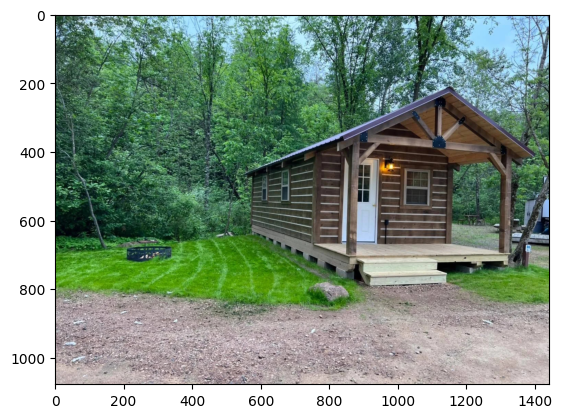

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

%matplotlib inline

img = cv.imread("test7.jpg")

_ = plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

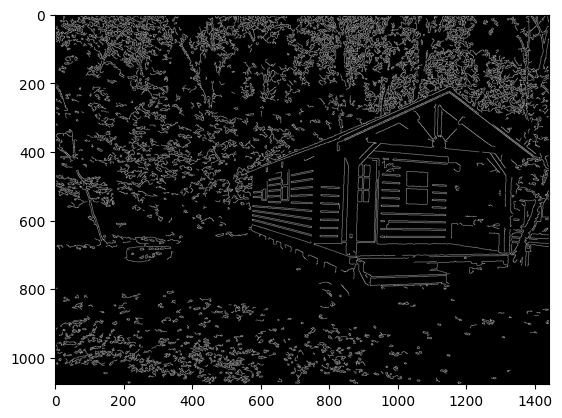

In [3]:
gray = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
gray = cv.GaussianBlur(gray, (5, 5), 1.5)
edges = cv.Canny(gray, 80, 200)

plt.imshow(edges, cmap="gray")

In [28]:
get_color = lambda i: (i % 3 * 255, (i + 1) % 3 * 255, (i + 2) % 3 * 255)

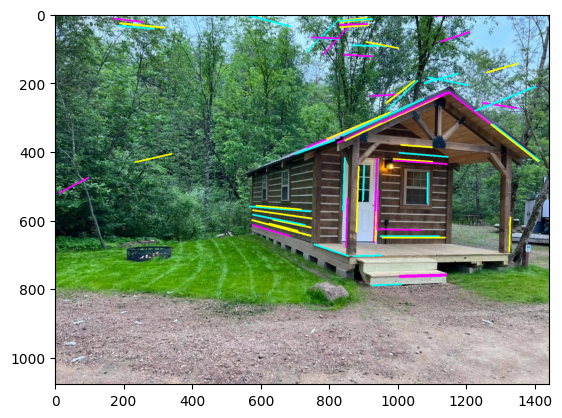

In [29]:
all_lines = cv.HoughLinesP(edges, 1, np.pi / 180, 15, minLineLength=80, maxLineGap=8)

x_guy = img.copy()

for i, line in enumerate(all_lines):
	cv.line(x_guy, line[0, :2], line[0, 2:], get_color(i), 3)

plt.imshow(cv.cvtColor(x_guy, cv.COLOR_BGR2RGB))

Having gotten a set of lines, we now need to cull it to get the lines of interest, those we wish to establish our axis with. This step requires manual intervention

In [5]:
# select two points for each of the three lines we want to use as the axis of the ground plane
# ideally i could just use one point to select a line using least squares but simplicity trumps ideality (i'm tired)

%matplotlib qt

# (x1, x2), (y1, y2), (z1, z2)
plt.imshow(cv.cvtColor(x_guy, cv.COLOR_BGR2RGB))
lines_raw = plt.ginput(6, 120)

In [7]:
%matplotlib inline
lines = [lines_raw[:2], lines_raw[2:4], lines_raw[4:]]
lines

[[(np.float64(871.1666666666666), np.float64(703.5833333333333)),
  (np.float64(952.8333333333334), np.float64(700.6666666666666))],
 [(np.float64(850.7499999999999), np.float64(700.6666666666666)),
  (np.float64(751.5833333333334), np.float64(668.5833333333333))],
 [(np.float64(844.9166666666666), np.float64(677.3333333333333)),
  (np.float64(850.7499999999999), np.float64(537.3333333333333))]]

In [17]:
# test 1: slope similarity, cull all lines too dissimilar in slope
from tqdm import tqdm

axis_candidates = []

for (a1, b1), (a2, b2) in lines:
	candidates = []
	
	target_slope = (b2 - b1) / (a2 - a1)
	print(target_slope)

	for ((x1, y1, x2, y2), ) in all_lines:
		if x1 == x2:
			continue
		
		slope = (y2 - y1) / (x2 - x1)

		if slope == 0:
			continue

		ratio = max(slope / target_slope, target_slope / slope)
		if 0.5 <= ratio and ratio <= 1.5:
			candidates.append(((x1, y1), (x2, y2)))

	axis_candidates.append(candidates)

-0.03571428571428522
0.32352941176470673
-24.000000000000313


In [15]:
len(axis_candidates[0]), len(axis_candidates[1]), len(axis_candidates[2])

(3, 4, 3)

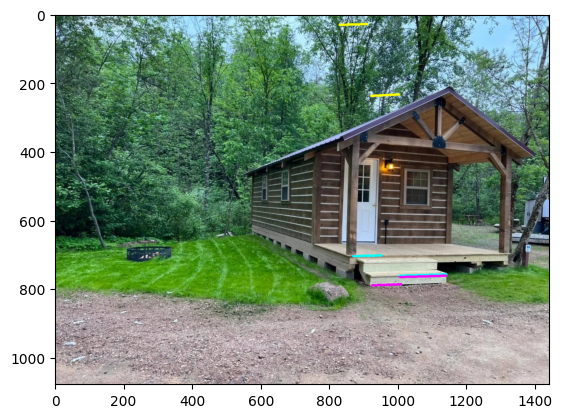

In [30]:
x_guy = img.copy()

# draw all x axis candidates
for i, line in enumerate(axis_candidates[0]):
	cv.line(x_guy, line[0], line[1], get_color(i), 5)

plt.imshow(cv.cvtColor(x_guy, cv.COLOR_BGR2RGB))

In [25]:
axes = []

for i, candidates in enumerate(axis_candidates):
	min_error = 10e9
	best_line = None
	
	(a1, b1), (a2, b2) = lines[i]

	for (x1, y1), (x2, y2) in candidates:
		error = 1/4 * (np.abs(x1 - a1) + np.abs(x2 - a2) + np.abs(y1 - b1) + np.abs(y2 - b2))

		if error < min_error:
			min_error = error
			best_line = ((x1, y1), (x2, y2))

	axes.append(best_line)

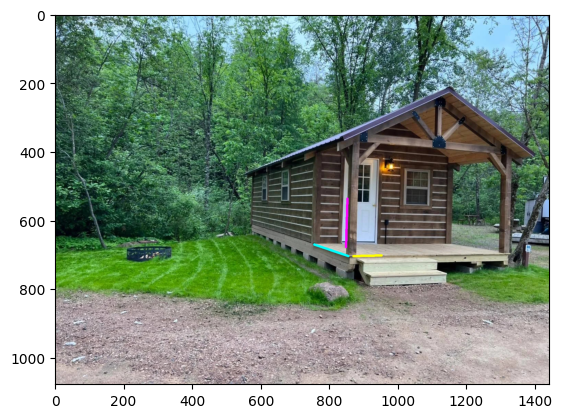

In [32]:
axes_guy = img.copy()

# draw the axes
for i, line in enumerate(axes):
	cv.line(axes_guy, line[0], line[1], get_color(i), 5)

plt.imshow(cv.cvtColor(axes_guy, cv.COLOR_BGR2RGB))

Now that we've established the axes, we find their vanishing points to recover the extrinsic rotation matrix & estimate the camera focal length